In [1]:
# Part 1: Imports and Setup
# ==============================================================================

import os
import numpy as np
import pandas as pd
import librosa
import soundfile
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
# Define paths to the dataset and where to save models
DATA_PATH = os.path.join("..", "data", "raw", "RAVDESS_Dataset")
MODELS_PATH = os.path.join("..", "src", "models")
PROCESSED_DATA_PATH_MALE = os.path.join("..", "data", "processed", "male_features")
PROCESSED_DATA_PATH_FEMALE = os.path.join("..", "data", "processed", "female_features")

# Define the emotions and genders
EMOTIONS = ['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
GENDERS = ['male', 'female']

# Define the number of MFCCs to extract
N_MFCC = 40

In [3]:
# Part 2: Feature Extraction and Data Preparation
# ==============================================================================

def extract_features(file_name):
    """
    Extracts MFCCs, Chroma, and Mel spectrograms from an audio file.
    
    Args:
        file_name (str): The path to the audio file.
    
    Returns:
        np.array: A NumPy array of concatenated audio features.
    """
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate

        if X.ndim > 1:
            X = X.mean(axis=1) # Convert to mono

        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=N_MFCC)
        chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
        mel = librosa.feature.melspectrogram(y=X, sr=sample_rate)

        # Concatenate features and take the mean of each
        features = np.concatenate((
            np.mean(mfccs.T, axis=0),
            np.mean(chroma.T, axis=0),
            np.mean(mel.T, axis=0)
        ))
    return features


def load_data():
    """
    Loads the RAVDESS dataset, extracts features, and labels each sample.
    
    Returns:
        tuple: A tuple containing two pandas DataFrames (emotion_df, gender_df).
    """
    processed_files_exist = (os.path.exists(PROCESSED_DATA_PATH_FEMALE) and 
                             len(os.listdir(PROCESSED_DATA_PATH_FEMALE)) > 0 and 
                             os.path.exists(PROCESSED_DATA_PATH_MALE) and 
                             len(os.listdir(PROCESSED_DATA_PATH_MALE)) > 0)

    if processed_files_exist:
        print("Loading processed data from files...")
        female_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH_FEMALE, 'female_features.csv'))
        male_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH_MALE, 'male_features.csv'))
        
        # Reconstruct the DataFrames from CSVs
        female_df['feature'] = female_df['feature'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
        male_df['feature'] = male_df['feature'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

        emotion_df = pd.concat([female_df, male_df])
        gender_df = pd.concat([female_df, male_df])

        return emotion_df, gender_df
    
    else:
        emotion_features, emotion_labels = [], []
        gender_features, gender_labels = [], []
        
        os.makedirs(PROCESSED_DATA_PATH_FEMALE, exist_ok=True)
        os.makedirs(PROCESSED_DATA_PATH_MALE, exist_ok=True)

        all_files = []
        for dir_name in os.listdir(DATA_PATH):
            actor_path = os.path.join(DATA_PATH, dir_name)
            if os.path.isdir(actor_path):
                all_files.extend([os.path.join(actor_path, f) for f in os.listdir(actor_path) if f.endswith('.wav')])
        
        print("Extracting features from audio files...")
        for file_path in tqdm(all_files):
            file_name = os.path.basename(file_path)
            
            # Ensure the file has the correct naming convention ---
            if not file_name.endswith('.wav') or len(file_name.split('-')) != 7:
                print(f"Skipping file with invalid name: {file_name}")
                continue

            parts = file_name.split('-')
            
            actor_id = int(parts[6].split('.')[0])
            gender_label = 'male' if actor_id % 2 != 0 else 'female'
            
            emotion_id = int(parts[2])
            if emotion_id > 0 and emotion_id <= len(EMOTIONS):
                emotion_label = EMOTIONS[emotion_id - 1]
            else:
                continue

            try:
                features = extract_features(file_path)
                
                emotion_features.append(features)
                emotion_labels.append(emotion_label)

                gender_features.append(features)
                gender_labels.append(gender_label)
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
                continue

        emotion_df = pd.DataFrame({'feature': emotion_features, 'emotion': emotion_labels})
        gender_df = pd.DataFrame({'feature': gender_features, 'gender': gender_labels})

        # Save the processed data to CSV files
        female_df = gender_df[gender_df['gender'] == 'female'].copy()
        male_df = gender_df[gender_df['gender'] == 'male'].copy()
        
        female_df.to_csv(os.path.join(PROCESSED_DATA_PATH_FEMALE, 'female_features.csv'), index=False)
        male_df.to_csv(os.path.join(PROCESSED_DATA_PATH_MALE, 'male_features.csv'), index=False)

        print("\nProcessed data saved to CSV files for future use.")
        return emotion_df, gender_df

# Load the data
emotion_df, gender_df = load_data()

Loading processed data from files...


In [4]:
# Part 3: Model Building and Training (Gender Detection)
# ==============================================================================

print("\n--- Building and Training Gender Detection Model ---")

# Prepare data for gender model
X_gender = np.array(gender_df['feature'].tolist())
y_gender = np.array(gender_df['gender'].tolist())

# Encode the labels to numerical format (male=0, female=1)
gender_encoder = LabelEncoder()
y_gender_encoded = gender_encoder.fit_transform(y_gender)
y_gender_categorical = to_categorical(y_gender_encoded)

# Split data into training and testing sets
X_gender_train, X_gender_test, y_gender_train, y_gender_test = train_test_split(
    X_gender, y_gender_categorical, test_size=0.2, random_state=42
)

# Reshape data for Conv1D layer
X_gender_train = X_gender_train.reshape(X_gender_train.shape[0], X_gender_train.shape[1], 1)
X_gender_test = X_gender_test.reshape(X_gender_test.shape[0], X_gender_test.shape[1], 1)

# Build the model
gender_model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_gender_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(GENDERS), activation='softmax')
])

gender_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gender_model.summary()

print("\nTraining Gender Detection Model...")
gender_history = gender_model.fit(
    X_gender_train, 
    y_gender_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_gender_test, y_gender_test),
    verbose=1
)

# Save the trained model
gender_model.save(os.path.join(MODELS_PATH, 'gender_model.h5'))
print("\nGender detection model saved successfully!")



--- Building and Training Gender Detection Model ---


C:\Users\prath\Desktop\Emotion_Detection_Voice\venv_emotion_new\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 176, 64)             │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 88, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 88, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 84, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 42, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 42, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5376)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,376,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,418,498 (5.41 MB)

 Trainable params: 1,418,498 (5.41 MB)

 Non-trainable params: 0 (0.00 B)


Training Gender Detection Model...
Epoch 1/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6562 - loss: 2.1362

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5968 - loss: 2.2461

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5799 - loss: 2.1034

14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5799 - loss: 1.9328

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5859 - loss: 1.7985

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5946 - loss: 1.6925

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6037 - loss: 1.6022

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6573 - loss: 1.1015 - val_accuracy: 0.8240 - val_loss: 0.3788


Epoch 2/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9062 - loss: 0.2896

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8703 - loss: 0.3299

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8539 - loss: 0.3419

14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8411 - loss: 0.3612

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8318 - loss: 0.3784

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8227 - loss: 0.3956

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8185 - loss: 0.4035

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8106 - loss: 0.4176 - val_accuracy: 0.9360 - val_loss: 0.2446


Epoch 3/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9062 - loss: 0.2727

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9066 - loss: 0.2669

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8985 - loss: 0.2773

14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8927 - loss: 0.2827

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8903 - loss: 0.2846

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8901 - loss: 0.2836

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8909 - loss: 0.2812

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8921 - loss: 0.2787

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9008 - loss: 0.2613 - val_accuracy: 0.9480 - val_loss: 0.1434


Epoch 4/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9062 - loss: 0.3473

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9233 - loss: 0.2406

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9154 - loss: 0.2467

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9128 - loss: 0.2478

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9105 - loss: 0.2447

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9106 - loss: 0.2409

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9110 - loss: 0.2371

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9198 - loss: 0.2103 - val_accuracy: 0.9800 - val_loss: 0.0744


Epoch 5/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8750 - loss: 0.2366

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9015 - loss: 0.2050

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9166 - loss: 0.1783

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9234 - loss: 0.1646

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9270 - loss: 0.1574

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9297 - loss: 0.1524

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9320 - loss: 0.1488

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9336 - loss: 0.1473

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9449 - loss: 0.1345 - val_accuracy: 0.9800 - val_loss: 0.0604


Epoch 6/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9062 - loss: 0.2134

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9335 - loss: 0.1541

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9397 - loss: 0.1449

14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9439 - loss: 0.1371

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9478 - loss: 0.1316

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9506 - loss: 0.1278

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9525 - loss: 0.1247

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9619 - loss: 0.1082 - val_accuracy: 0.9880 - val_loss: 0.0353


Epoch 7/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9375 - loss: 0.0852

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9501 - loss: 0.0771

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9515 - loss: 0.0803

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9523 - loss: 0.0857

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9530 - loss: 0.0922

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9527 - loss: 0.0981

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9533 - loss: 0.1009

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9589 - loss: 0.1099 - val_accuracy: 0.9880 - val_loss: 0.0636


Epoch 8/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 0.0073

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.0765

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9677 - loss: 0.0730

14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9697 - loss: 0.0848

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9694 - loss: 0.0990

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9691 - loss: 0.1042

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9690 - loss: 0.1064

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9679 - loss: 0.1165 - val_accuracy: 0.9760 - val_loss: 0.0674


Epoch 9/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9688 - loss: 0.1411

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9656 - loss: 0.1311

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9660 - loss: 0.1234

14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9681 - loss: 0.1138

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9681 - loss: 0.1110

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9685 - loss: 0.1079

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9691 - loss: 0.1044

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9699 - loss: 0.1003

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9749 - loss: 0.0767 - val_accuracy: 0.9960 - val_loss: 0.0288


Epoch 10/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9062 - loss: 0.4216

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9499 - loss: 0.1955

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9611 - loss: 0.1445

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9661 - loss: 0.1212

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9692 - loss: 0.1075

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9710 - loss: 0.1001

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9720 - loss: 0.0964

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9770 - loss: 0.0750 - val_accuracy: 0.9920 - val_loss: 0.0232


Epoch 11/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9688 - loss: 0.0856

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9791 - loss: 0.0736

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9823 - loss: 0.0661

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9823 - loss: 0.0633

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9818 - loss: 0.0615

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9819 - loss: 0.0606

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9819 - loss: 0.0607

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9820 - loss: 0.0618 - val_accuracy: 0.9920 - val_loss: 0.0207


Epoch 12/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0154

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9856 - loss: 0.0608

12/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0580

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9847 - loss: 0.0547

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9853 - loss: 0.0513

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9859 - loss: 0.0486

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9900 - loss: 0.0358 - val_accuracy: 0.9960 - val_loss: 0.0220


Epoch 13/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0111

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0111

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9981 - loss: 0.0157

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9968 - loss: 0.0180

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9949 - loss: 0.0214

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9942 - loss: 0.0227

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9938 - loss: 0.0234

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9920 - loss: 0.0294 - val_accuracy: 0.9960 - val_loss: 0.0185


Epoch 14/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0120

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9817 - loss: 0.0466

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9827 - loss: 0.0451

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9836 - loss: 0.0426

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9842 - loss: 0.0408

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9850 - loss: 0.0392

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9853 - loss: 0.0387

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9870 - loss: 0.0364 - val_accuracy: 0.9920 - val_loss: 0.0348


Epoch 15/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9688 - loss: 0.0732

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9872 - loss: 0.0346

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9886 - loss: 0.0289

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9892 - loss: 0.0281

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9886 - loss: 0.0295

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9886 - loss: 0.0298

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9890 - loss: 0.0326 - val_accuracy: 0.9920 - val_loss: 0.0337


Epoch 16/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 6.9198e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9986 - loss: 0.0095    

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9971 - loss: 0.0135

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9958 - loss: 0.0168

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9950 - loss: 0.0185

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9944 - loss: 0.0196

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9920 - loss: 0.0249 - val_accuracy: 0.9960 - val_loss: 0.0187


Epoch 17/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0028

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9986 - loss: 0.0146 

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9978 - loss: 0.0178

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9969 - loss: 0.0209

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9961 - loss: 0.0221

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9958 - loss: 0.0221

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9950 - loss: 0.0207 - val_accuracy: 0.9920 - val_loss: 0.0271


Epoch 18/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9375 - loss: 0.0726

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9762 - loss: 0.0317 

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9817 - loss: 0.0270

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9841 - loss: 0.0253

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9860 - loss: 0.0243

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9872 - loss: 0.0235

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9910 - loss: 0.0210 - val_accuracy: 0.9920 - val_loss: 0.0525


Epoch 19/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0019

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9980 - loss: 0.0094

12/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9952 - loss: 0.0143

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9944 - loss: 0.0159

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9942 - loss: 0.0165

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9938 - loss: 0.0171

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9920 - loss: 0.0200 - val_accuracy: 0.9920 - val_loss: 0.0261


Epoch 20/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0132

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0100

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9998 - loss: 0.0096

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9982 - loss: 0.0112

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9973 - loss: 0.0127

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9963 - loss: 0.0151

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9920 - loss: 0.0261 - val_accuracy: 0.9920 - val_loss: 0.0397


Epoch 21/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0074

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0055

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9979 - loss: 0.0128

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9962 - loss: 0.0190

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9954 - loss: 0.0213

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9948 - loss: 0.0227

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9930 - loss: 0.0276 - val_accuracy: 0.9920 - val_loss: 0.0207


Epoch 22/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9688 - loss: 0.0763

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9637 - loss: 0.0991 

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9709 - loss: 0.0787

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9745 - loss: 0.0707

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9770 - loss: 0.0644

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9787 - loss: 0.0597

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9850 - loss: 0.0397 - val_accuracy: 0.9840 - val_loss: 0.0606


Epoch 23/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9688 - loss: 0.3743

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9822 - loss: 0.1808

12/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9842 - loss: 0.1412

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9852 - loss: 0.1193

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9858 - loss: 0.1047

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9865 - loss: 0.0939

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9900 - loss: 0.0439 - val_accuracy: 0.9920 - val_loss: 0.0393


Epoch 24/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0036

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0042

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9991 - loss: 0.0067

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9982 - loss: 0.0136

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9978 - loss: 0.0176

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9971 - loss: 0.0210

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9940 - loss: 0.0337 - val_accuracy: 0.9920 - val_loss: 0.0152


Epoch 25/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0058

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0070

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0069

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9988 - loss: 0.0101

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9976 - loss: 0.0133

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9966 - loss: 0.0154

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9961 - loss: 0.0166

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9940 - loss: 0.0217 - val_accuracy: 0.9960 - val_loss: 0.0106


Epoch 26/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0037

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9981 - loss: 0.0051

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9959 - loss: 0.0082

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9932 - loss: 0.0136

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9910 - loss: 0.0202

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9899 - loss: 0.0234

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9893 - loss: 0.0249

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9870 - loss: 0.0307 - val_accuracy: 0.9840 - val_loss: 0.0446


Epoch 27/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0167

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9916 - loss: 0.0265

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9922 - loss: 0.0228

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9932 - loss: 0.0201

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9940 - loss: 0.0185

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9941 - loss: 0.0179

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9942 - loss: 0.0176

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9950 - loss: 0.0148 - val_accuracy: 0.9920 - val_loss: 0.0187


Epoch 28/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 1.4672e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0037    

12/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9988 - loss: 0.0103

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9979 - loss: 0.0160

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9977 - loss: 0.0176

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9977 - loss: 0.0178

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9970 - loss: 0.0190 - val_accuracy: 0.9920 - val_loss: 0.0382


Epoch 29/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9688 - loss: 0.0312

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9721 - loss: 0.0319

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9799 - loss: 0.0237

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9841 - loss: 0.0198

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9863 - loss: 0.0186

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9876 - loss: 0.0181

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9879 - loss: 0.0191

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9890 - loss: 0.0232 - val_accuracy: 0.9880 - val_loss: 0.0229


Epoch 30/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9688 - loss: 0.0325

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9820 - loss: 0.0337

12/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9824 - loss: 0.0355

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9832 - loss: 0.0347

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9830 - loss: 0.0357

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9832 - loss: 0.0358

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9850 - loss: 0.0354 - val_accuracy: 0.9920 - val_loss: 0.0491


Epoch 31/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 3.6718e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0036    

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9979 - loss: 0.0081

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9955 - loss: 0.0147

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9943 - loss: 0.0184

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9934 - loss: 0.0208

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9929 - loss: 0.0219

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9910 - loss: 0.0257 - val_accuracy: 0.9920 - val_loss: 0.0342


Epoch 32/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0018

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9991 - loss: 0.0067

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9974 - loss: 0.0083

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9960 - loss: 0.0108

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9958 - loss: 0.0111

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9959 - loss: 0.0112

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9970 - loss: 0.0113 - val_accuracy: 0.9960 - val_loss: 0.0164


Epoch 33/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 3.5128e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9951 - loss: 0.0077    

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9954 - loss: 0.0073

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9952 - loss: 0.0077

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9952 - loss: 0.0079

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9950 - loss: 0.0082

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9944 - loss: 0.0090

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9910 - loss: 0.0166 - val_accuracy: 0.9920 - val_loss: 0.0113


Epoch 34/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0063

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9899 - loss: 0.0339

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9897 - loss: 0.0363

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9908 - loss: 0.0329

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9918 - loss: 0.0299

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9919 - loss: 0.0289

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9920 - loss: 0.0231 - val_accuracy: 0.9880 - val_loss: 0.0460


Epoch 35/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0128

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9962 - loss: 0.0116

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9929 - loss: 0.0152

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9910 - loss: 0.0183

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9902 - loss: 0.0203

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9902 - loss: 0.0207

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9910 - loss: 0.0201 - val_accuracy: 0.9920 - val_loss: 0.0509


Epoch 36/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0043

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9987 - loss: 0.0041

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9965 - loss: 0.0065

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9964 - loss: 0.0069

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9965 - loss: 0.0071

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9967 - loss: 0.0070

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9980 - loss: 0.0056 - val_accuracy: 0.9920 - val_loss: 0.0503


Epoch 37/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 3.1338e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0050    

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9995 - loss: 0.0053

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9982 - loss: 0.0063

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9974 - loss: 0.0074

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9963 - loss: 0.0094

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9955 - loss: 0.0110

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9920 - loss: 0.0195 - val_accuracy: 0.9760 - val_loss: 0.1167


Epoch 38/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 1.9250e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9924 - loss: 0.0247    

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9923 - loss: 0.0458

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9915 - loss: 0.0668

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9905 - loss: 0.0739

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9901 - loss: 0.0750

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9900 - loss: 0.0740

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9890 - loss: 0.0678 - val_accuracy: 0.9960 - val_loss: 0.0125


Epoch 39/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0015

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9949 - loss: 0.0460

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9931 - loss: 0.0494

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9930 - loss: 0.0452

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9927 - loss: 0.0412

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9927 - loss: 0.0386

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9930 - loss: 0.0237 - val_accuracy: 0.9880 - val_loss: 0.0360


Epoch 40/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0010

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9924 - loss: 0.0131

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9940 - loss: 0.0119

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9945 - loss: 0.0128

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9947 - loss: 0.0130

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9950 - loss: 0.0128

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9952 - loss: 0.0125

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9960 - loss: 0.0111 - val_accuracy: 0.9960 - val_loss: 0.0092


Epoch 41/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0013

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9945 - loss: 0.0073

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9922 - loss: 0.0151

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9913 - loss: 0.0215

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9909 - loss: 0.0241

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9910 - loss: 0.0247

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9930 - loss: 0.0230 - val_accuracy: 0.9920 - val_loss: 0.0124


Epoch 42/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0141

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9951 - loss: 0.0382

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9948 - loss: 0.0345

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9941 - loss: 0.0331

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9939 - loss: 0.0308

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9938 - loss: 0.0293

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9939 - loss: 0.0279

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9940 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 0.0088


Epoch 43/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0188

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0113

12/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0096

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9997 - loss: 0.0098

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9994 - loss: 0.0101

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9993 - loss: 0.0100

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9980 - loss: 0.0090 - val_accuracy: 0.9880 - val_loss: 0.0327


Epoch 44/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0023

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0103

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9988 - loss: 0.0110

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9974 - loss: 0.0119

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9967 - loss: 0.0120

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9963 - loss: 0.0119

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9962 - loss: 0.0116

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9960 - loss: 0.0092 - val_accuracy: 1.0000 - val_loss: 0.0060


Epoch 45/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0012

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0012

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0012

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0011

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9993 - loss: 0.0018

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9990 - loss: 0.0022

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9988 - loss: 0.0025

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9970 - loss: 0.0093 - val_accuracy: 0.9920 - val_loss: 0.0106


Epoch 46/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0033

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9981 - loss: 0.0069

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9973 - loss: 0.0063

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9975 - loss: 0.0056

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9976 - loss: 0.0055

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9976 - loss: 0.0055

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9975 - loss: 0.0056

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9970 - loss: 0.0072 - val_accuracy: 0.9880 - val_loss: 0.0336


Epoch 47/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0121

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9968 - loss: 0.0102

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9966 - loss: 0.0095

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9970 - loss: 0.0082

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9971 - loss: 0.0075

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9971 - loss: 0.0069

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9973 - loss: 0.0065

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9980 - loss: 0.0039 - val_accuracy: 0.9920 - val_loss: 0.0199


Epoch 48/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0019

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9991 - loss: 0.0019

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9979 - loss: 0.0028

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9977 - loss: 0.0029

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9975 - loss: 0.0034

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9975 - loss: 0.0036

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9974 - loss: 0.0040

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9970 - loss: 0.0057 - val_accuracy: 0.9880 - val_loss: 0.0137


Epoch 49/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0027

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0027

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0026

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0025

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0025

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9997 - loss: 0.0030

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9994 - loss: 0.0037

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9970 - loss: 0.0101 - val_accuracy: 0.9880 - val_loss: 0.0288


Epoch 50/50


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9375 - loss: 0.0896

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9745 - loss: 0.0435

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9823 - loss: 0.0309

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9853 - loss: 0.0256

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9872 - loss: 0.0222

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9887 - loss: 0.0196

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9898 - loss: 0.0177

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9960 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 0.0020



Gender detection model saved successfully!


In [5]:
# Part 4: Model Building and Training (Emotion Detection - Female Voices Only)
# ==============================================================================

print("\n--- Building and Training Emotion Detection Model (Female Voices Only) ---")

# Filter for only female voices
emotion_female_df = emotion_df[gender_df['gender'] == 'female']

# Prepare data for emotion model
X_emotion_female = np.array(emotion_female_df['feature'].tolist())
y_emotion_female = np.array(emotion_female_df['emotion'].tolist())

# Encode emotion labels
emotion_encoder = LabelEncoder()
y_emotion_female_encoded = emotion_encoder.fit_transform(y_emotion_female)
y_emotion_female_categorical = to_categorical(y_emotion_female_encoded)

# Split data into training and testing sets
X_emotion_train, X_emotion_test, y_emotion_train, y_emotion_test = train_test_split(
    X_emotion_female, y_emotion_female_categorical, test_size=0.2, random_state=42
)

# Reshape data for Conv1D layer
X_emotion_train = X_emotion_train.reshape(X_emotion_train.shape[0], X_emotion_train.shape[1], 1)
X_emotion_test = X_emotion_test.reshape(X_emotion_test.shape[0], X_emotion_test.shape[1], 1)

# Build the model
emotion_model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_emotion_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Conv1D(filters=256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(EMOTIONS), activation='softmax')
])

emotion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
emotion_model.summary()

print("\nTraining Emotion Detection Model...")
emotion_history = emotion_model.fit(
    X_emotion_train,
    y_emotion_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_emotion_test, y_emotion_test),
    verbose=1
)

# Save the trained model
emotion_model.save(os.path.join(MODELS_PATH, 'emotion_model.h5'))
print("\nEmotion detection model saved successfully!")



--- Building and Training Emotion Detection Model (Female Voices Only) ---


KeyError: 'emotion'


--- Evaluating Gender Detection Model ---
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000

Confusion Matrix:
[[128   0]
 [  0 122]]


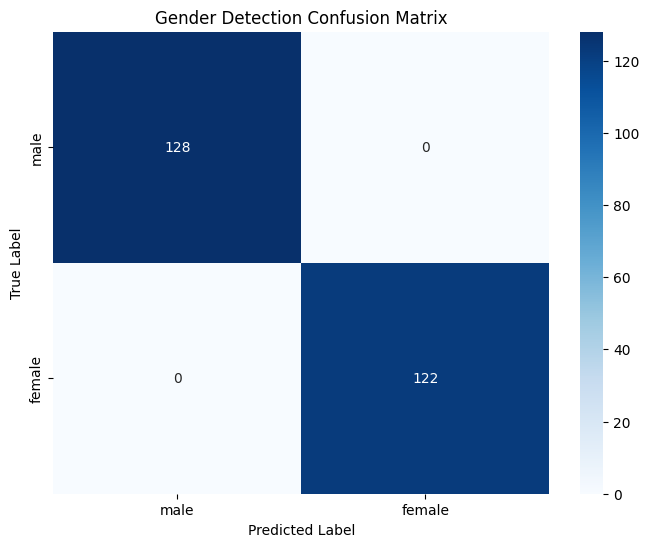



--- Evaluating Emotion Detection Model ---


NameError: name 'emotion_model' is not defined

In [6]:
# Part 5: Model Evaluation and Metrics
# ==============================================================================

print("\n--- Evaluating Gender Detection Model ---")
# Make predictions on the test set
y_gender_pred = gender_model.predict(X_gender_test)
y_gender_pred_classes = np.argmax(y_gender_pred, axis=1)
y_gender_true = np.argmax(y_gender_test, axis=1)

# Calculate and print metrics
print(f"Accuracy: {accuracy_score(y_gender_true, y_gender_pred_classes):.4f}")
print(f"Precision: {precision_score(y_gender_true, y_gender_pred_classes, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_gender_true, y_gender_pred_classes, average='weighted'):.4f}")

# Generate and display the confusion matrix
cm_gender = confusion_matrix(y_gender_true, y_gender_pred_classes)
print("\nConfusion Matrix:")
print(cm_gender)

# Plotting the confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues', xticklabels=GENDERS, yticklabels=GENDERS)
plt.title('Gender Detection Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print("\n\n--- Evaluating Emotion Detection Model ---")
# Make predictions on the test set
y_emotion_pred = emotion_model.predict(X_emotion_test)
y_emotion_pred_classes = np.argmax(y_emotion_pred, axis=1)
y_emotion_true = np.argmax(y_emotion_test, axis=1)

# Calculate and print metrics
print(f"Accuracy: {accuracy_score(y_emotion_true, y_emotion_pred_classes):.4f}")
print(f"Precision: {precision_score(y_emotion_true, y_emotion_pred_classes, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_emotion_true, y_emotion_pred_classes, average='weighted'):.4f}")

# Generate and display the confusion matrix
cm_emotion = confusion_matrix(y_emotion_true, y_emotion_pred_classes)
print("\nConfusion Matrix:")
print(cm_emotion)

# Plotting the confusion matrix for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm_emotion, annot=True, fmt='d', cmap='Greens', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title('Emotion Detection Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()